### key topics: python | regression | feature engineering | visualization | xgboost

# Introduction and goals

At the end of last semester I gave a two part tutorial to my department's R users group where we introduced the basics of machine learning, data cleaning and paramater tuning by following along with an R derivative of  'Hands-On Machine learning with Scikit-Learn and TensorFlow'  by Aurélien Géron and then building some XGBoost models to try to improve predictions through the use of different algorithms, parameter tuning, and some basic ensembling. One of the follow up exercises I had suggested was trying to add in more features to improve the models not only through tuning algorithms, but through the use of better data.

On my spare time I started sniffing around and found  two datasets that make a good starting point for trying to add to the original features and build better predictive models. And since I was now doing this outside of the confines of the R users group, I have switched over to python for the selfish reason of wanting to keep my python data visualization skills sharp.

The new data I used:

A list of the latitude and longitude of cities in California: 
http://52.26.186.219/internships/useit/content/cities-california-latitude-and-longitude

Historical population data for cities in California (including the year 1990, which is the year the original housing price data was collected :
http://www.dof.ca.gov/Reports/Demographic_Reports/documents/2010-1850_STCO_IncCities-FINAL.xls

I have cleaned the originals (a.k.a. de-excel'd) and put them on Kaggle here: https://www.kaggle.com/camnugent/california-housing-feature-engineering

There is the potential to add a lot of different features based on these dataframes, but I decided to focus on engineering the following (predominantly geospatial) features for each data point:
1. The name of the nearest city.
2. The distance from the district's coordinates to the nearest city.
3. The population of the nearest city.
4. The nearest 'big city' (a big city is categorized as >500,000 residents in the given year, 1990).
5. The distance to the nearest 'big city'.

Below I walk through the code I used to add these 5 bits of information to each housing district's list of predictors. I then develop some maps/plots to help visualize the new features and see what information was added, and finally I train an xgboot model on the expanded feature set and assess its performance relative to the previous models I had built using the original data only.


Before we start a few limitations to note on the data we are adding -  I am not sure if these are comprehensive lists of the cities in California. In fact there is imperfect overlap between the coordinates and population data (so some of the smaller towns are not prefectly represented in the added features)

If there are more good features you can think of engineering I encourage you to give the notebook a fork and try them out!


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from geopy.distance import vincenty

import gc


In [2]:

#######
# read in the data
######
housing = pd.read_csv('../input/california-housing-prices/housing.csv')
housing.head()


city_lat_long = pd.read_csv('../input/california-housing-feature-engineering/cal_cities_lat_long.csv')
city_pop_data = pd.read_csv('../input/california-housing-feature-engineering/cal_populations_city.csv')
county_pop_data = pd.read_csv('../input/california-housing-feature-engineering/cal_populations_county.csv')



The code below iterates through the coordinates dataframe and builds a dictonary with the city names as the keys and a tuple of the corresponding (latitude, longitude) as the values. 

In [3]:
#########
# Engineer more features here prior to 
# passing data in for imputation and one hot encoding
#########

city_coords = {}

for dat in city_lat_long.iterrows():
    row = dat[1]
    if row['Name'] not in city_pop_data['City'].values:   
        continue           
    else: 
        city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))


"""
NOTE: originally I had the code shown below, 
but I had to change it because I only want to 
deal with cities where there
is both location and population data.

city_coords = {}
for dat in city_lat_long.iterrows():
    row = dat[1]
    city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))

#how I deiscovered the need for the change
present = []
absent = []
for city in city_coords.keys():
    if city in city_pop_data['City'].values:
        present.append(city)
    else:
        absent.append(city)
len(present)
len(absent)
absent
"""


Two functions are needed to find the distance to the nearest town, first one to determine the distance between two sets of coordinates, and second a function to try all pairwise comparisons and figure out which city is the closest.

For the first function,  geopy's vincenty function is used to determine the distance between two points on the earths surface using Vincenty's formulae (it accounts for the fact the world is a spheroid when doing the vector math). A quick example is shown below (form the geopy docs)

In [4]:
#two functions:
#1. take two lat long tuples as input
	#return the distance between the two
    #vincenty(tuple1, tuple2)

#example below
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
x = vincenty(newport_ri, cleveland_oh)
x #distance stored in km, see units on printing
print(x)
type(x.kilometers)

866.4554329011002 km


float

This next function just takes the vincenty function and uses it to compare a set of coordinates to all of the coordinates stored in a dictonary of locations to determine which location in the dictonary is closest.

In [5]:

#2. take a dict[city] = (lat, long) of locations and a tuple of lat long
	# run number 1 for each comparison and return a tuple with
	#the closest city's key + value and the distance between the points
    #the O(n) time here makes me weep and I am thinking of ways to improve it
def closest_point(location, location_dict):
    """ take a tuple of latitude and longitude and 
        compare to a dictonary of locations where
        key = location name and value = (lat, long)
        returns tuple of (closest_location , distance) """
    closest_location = None
    for city in location_dict.keys():
        distance = vincenty(location, location_dict[city]).kilometers
        if closest_location is None:
            closest_location = (city, distance)
        elif distance < closest_location[1]:
            closest_location = (city, distance)
    return closest_location


In [6]:
test = (39.524325, -122.293592) #likely 'Willows'
closest_point(test, city_coords)

('Willows', 8.598342477208991)

This next bit of code builds a dictonary of (city, population) (key, value) pairs and then goes through and builds a separate coordinate dictonary for only the big cities.

We use the April 1990 population data below, as the housing price information that we are trying to model  is based off of the 1990 California Census.

In [7]:

#run number 2 to determine both the nearest city, and then
	#also the nearest city with 1million people (subset the original dict)

city_pop_dict = {}
for dat in city_pop_data.iterrows():
    row = dat[1]
    city_pop_dict[row['City']] =  row['pop_april_1990']


big_cities = {}

for key, value in city_coords.items():
    if city_pop_dict[key] > 500000:
        big_cities[key] = value



The dictonaries and functions we created are then applied to the main housing dataframe to make the new data columns. This is done mainly using the pandas .apply() function.

In [9]:

#######
# adding closest city data to dataframes
#######

housing['close_city'] = housing.apply(lambda x: 
							closest_point((x['latitude'],x['longitude']),city_coords), axis = 1)
housing['close_city_name'] = [x[0] for x in housing['close_city'].values]
housing['close_city_dist'] = [x[1] for x in housing['close_city'].values]
housing['close_city_pop'] = housing.apply(lambda x: city_pop_dict[x['close_city_name']])

housing = housing.drop('close_city', axis=1)
housing.head()


#add the data relating to the points to the closest big city
housing['big_city'] = housing.apply(lambda x: 
							closest_point((x['latitude'],x['longitude']),big_cities), axis = 1)
housing['big_city_name'] = [x[0] for x in housing['big_city'].values]
housing['big_city_dist'] = [x[1] for x in housing['big_city'].values]

housing = housing.drop('big_city', axis=1)



In [10]:


#####
# pre-plot housekeeping
#####

#Housekeeping, plot background image load and new df for graphing

california_img=mpimg.imread('../input/california-housing-feature-engineering/california.png')

housing_plot = housing[['longitude','population','latitude', 'close_city_name','big_city_name','big_city_dist','median_house_value']]


# Visualizing the data

## 1. Map of the location and population of housing districts, along with a heatmap to show where homes are the most expensive.

This plot is almost directly from Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow' (Chapter 2).  It gives a good representation of the original dataset and provides a reference prior to our discussion of the engineered features below.

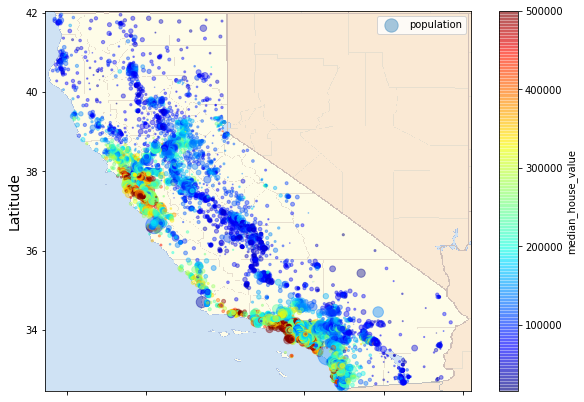

In [11]:
housing_plot.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
				s=housing_plot['population']/100, label='population', figsize=(10,7),
				c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()



## 2. Below we have a graph showing the size and location of the cities in the dataset.

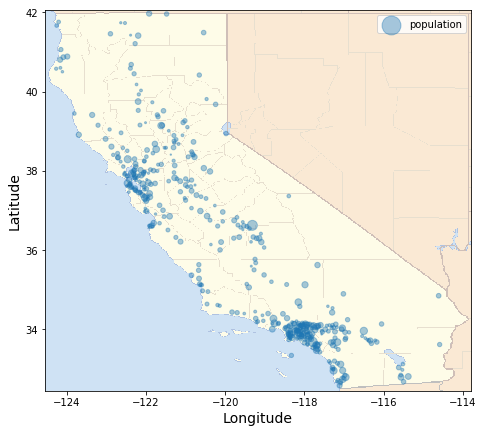

In [16]:

####
city_lat_long['Population'] = [city_pop_dict[x] if x in city_pop_dict.keys() 
												else 0 for x in city_lat_long['Name'].values]
# graph of the location of the cities and their size
city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
				s=housing_plot['population']/50, label='population', figsize=(10,7))

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()



## 3. Engineered Features - Length of vectors between districts and nearest town (Vincenty's formulae)

The map below provides a visualization of three of the features added to the data. The black lines represent the vectors connecting the districts to the nearest town. Based on these lines, the distance to the nearest town (length of black line), the population of the nearest town (point the black line arrives at) and a categorical for the name of the nearest town were assigned to the district.

These features help to capture the general trend of houses getting cheaper the further away from downtown one gets (a fairly universal pattern... with plenty of exceptions). They can also aid the model by providing a rough representation of more abstract aspects associated with position in town, such as the commute time for people working in city centers. The nearest town can also capture important effects such as 'who do you pay property taxes to?' and 'what is the infastructure like for this muniipality?' which are the types of things that could have impacts of the values of homes.

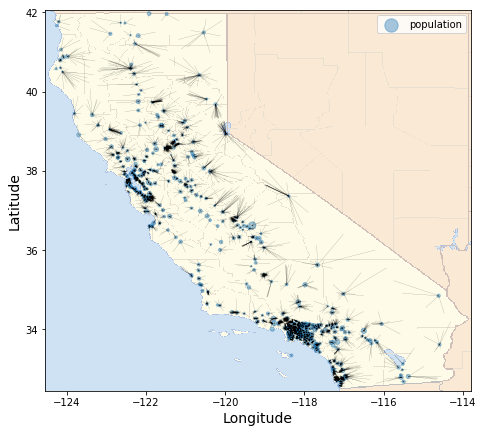

In [13]:

####
# graph of vectors connecting points to their nearest city

city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
				s=housing_plot['population']/100, label='population', figsize=(10,7))

for line in housing.iterrows():
	dat = line[1]
	x1 = dat['longitude']
	y1 = dat['latitude']
	p2 = city_coords[dat['close_city_name']]
	x2 = p2[1]
	y2 = p2[0]
	plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.1)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()



## 4. Other Engineered Features - Distance to the big city

This set of features shows which big city (San Francisco, San Jose, San Diego or Los Angeles... those are all really religious spanish names!) a given district is closest to. The cutoff for 'big city' was 500,000 people (this is 1990 data remember). The black lines here represent the same information as the previous plot, and each district was given a value for the distance to the nearest big city (Vincenty) and a categorical for the name of the nearest big city.  I decided to add these features in because the proximity to a large city is somthing I intuitively thought would impact a house price. Access to things like major aiports and major entertainment events/venues could all have a small but important effect of the price of a home.

Looking at the map below, we can see that this clustering also has an interesting side effect of effectively splitting California into quarters. So having the categorical San Francisco as the closest big city is roughly equivalent to being from the northern 1/4 of the state, while the San Diego category is roughly equivalent to the bottom 1/4 of California (I said roughy... don't get out the rulers!). So this feature may be adding some extra structure to the data in ways I had not initially intended.

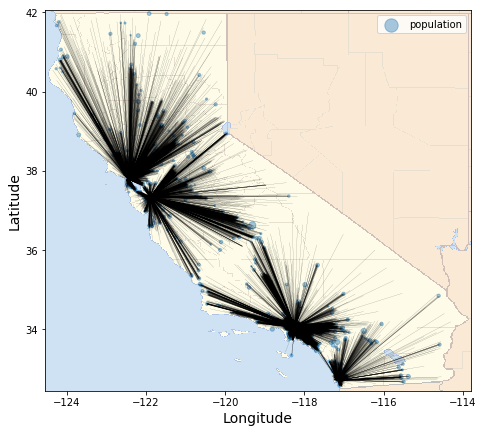

In [14]:

####
# graph of the vectors connecting districts to the nearest major city
# and a barplot of distance to the nearest major city


city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
				s=housing_plot['population']/100, label='population', figsize=(10,7))

for line in housing.iterrows():
	dat = line[1]
	x1 = dat['longitude']
	y1 = dat['latitude']
	p2 = big_cities[dat['big_city_name']]
	x2 = p2[1]
	y2 = p2[0]
	plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.1)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()



The large block of code below does some cleaning on the existing features, performs a train test split, one-hot encodes the categorical variables, scales the numerical variables and then recombines the data to produce the final, cleaned version of the train and test dataframes

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


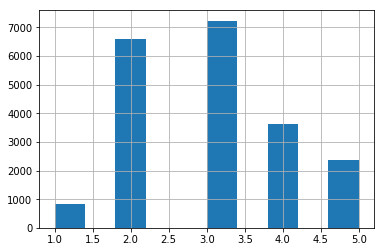

In [15]:

#####
# Alter existing features, train test split.
#####


# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing['ocean_proximity'][housing['ocean_proximity'] == '<1H OCEAN'] = 'LessThan1h'


#make a stratified split of the data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
	train_set = housing.loc[train_index]
	test_set = housing.loc[test_index]

for set_ in (train_set, test_set):
	set_.drop("income_cat", axis=1, inplace=True)

gc.collect()


def housing_data_clean(input_df):
	input_df['rooms_per_household'] = input_df['total_rooms']/input_df['households']
	input_df['bedrooms_per_household'] = input_df['total_bedrooms']/input_df['households']
	input_df['bedrooms_per_room'] = input_df['total_bedrooms']/input_df['total_rooms']
	input_df['population_per_household'] = input_df['population']/input_df['households']
	input_df = input_df.drop(['total_bedrooms','total_rooms'], axis=1)
	return input_df

train_set = housing_data_clean(train_set)
train_set.head()
#do the same to the test set at the same time so they remain consistent with one another!
test_set = housing_data_clean(test_set)

X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set['median_house_value'].values.astype(float)

X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].values.astype(float)




#####
# fill numerical values
#####

def fill_median(dataframe, cols):
	"""impute the mean for a list of columns in the dataframe"""
	for i in cols:
		dataframe[i].fillna(dataframe[i].median(skipna=True), inplace = True)
	return dataframe

def cols_with_missing_values(dataframe):
	""" query a dataframe and find the columns that have missing values"""
	return list(dataframe.columns[dataframe.isnull().any()])

def fill_value(dataframe, col, val):
	"""impute the value for a list column in the dataframe"""
	""" use this to impute the median of the train into the test"""
	dataframe[i].fillna(val, inplace = True)
	return dataframe


missing_vals = cols_with_missing_values(X_train)
X_train = fill_median(X_train, missing_vals)

for i in missing_vals:
	X_test = fill_value(X_test, i, X_train[i].median(skipna=True))



In [17]:


#####
# One hot encode the categoricals
#####


encoder1 = LabelBinarizer()

encoded_ocean_train_1hot = encoder1.fit_transform(X_train['ocean_proximity'])
 
#I'm using just transform below to ensure that the categories are sorted and used the same as in the train fit.
encoded_ocean_test_1hot = encoder1.transform(X_test['ocean_proximity']) 
													

encoder2 = LabelBinarizer()
encoded_train_close_city = encoder2.fit_transform(X_train['close_city_name'])
encoded_test_close_city = encoder2.transform(X_test['close_city_name'])
													


encoder3 = LabelBinarizer()
encoded_train_big_city = encoder3.fit_transform(X_train['big_city_name'])
encoded_test_big_city = encoder3.transform(X_test['big_city_name'])
													

all_classes = list(encoder1.classes_) + [x + '_city' for x in encoder2.classes_ ]  + [x + '_Bigcity' for x in encoder3.classes_]

train_bool_data = np.concatenate((encoded_ocean_train_1hot, encoded_train_close_city, encoded_train_big_city), axis=1)
test_bool_data = np.concatenate((encoded_ocean_test_1hot, encoded_test_close_city, encoded_test_big_city), axis=1)

train_cat_df = pd.DataFrame(train_bool_data,
	index = X_train.index, columns = all_classes )

test_cat_df = pd.DataFrame(test_bool_data,index = X_test.index, columns = all_classes)


In [18]:

###
# Combine and scale the dfs
###

X_train.drop(['ocean_proximity','close_city_name','big_city_name'], axis=1, inplace=True)
X_test.drop(['ocean_proximity','close_city_name','big_city_name'], axis=1, inplace=True)


num_cols = X_train.columns
num_train_index = X_train.index
num_test_index = X_test.index

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = pd.DataFrame(X_train,index = num_train_index, columns = num_cols)
X_test = pd.DataFrame(X_test,index = num_test_index, columns = num_cols)


X_train = pd.concat([X_train, train_cat_df], axis=1)
X_test = pd.concat([X_test, test_cat_df], axis=1)

gc.collect()


In [ ]:

#from here lets go in to an XGB model first,

import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)



y_mean = np.mean(y_train)
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,
    'silent': 1}

cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   nfold=5,
                   num_boost_round=5000,
                   early_stopping_rounds=50,
                   verbose_eval=10, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
num_boost_rounds

[0]	train-rmse:111260	test-rmse:111435
[10]	train-rmse:78355	test-rmse:80666.5
[20]	train-rmse:59863.2	test-rmse:64648
[30]	train-rmse:49553	test-rmse:56583.7
[40]	train-rmse:43569.3	test-rmse:52462.2
[50]	train-rmse:39950.9	test-rmse:50343.4
[60]	train-rmse:37559.4	test-rmse:49112.3
[70]	train-rmse:35850.7	test-rmse:48325.3
[80]	train-rmse:34486.1	test-rmse:47667.8
[90]	train-rmse:33669.7	test-rmse:47305.5
[100]	train-rmse:33032.8	test-rmse:47050.7
[110]	train-rmse:32460.6	test-rmse:46810
[120]	train-rmse:32000.1	test-rmse:46621.2
[130]	train-rmse:31611.9	test-rmse:46467.1
[140]	train-rmse:31200.5	test-rmse:46343.8
[150]	train-rmse:30845.4	test-rmse:46221
[160]	train-rmse:30481.5	test-rmse:46112.7
[170]	train-rmse:30147.2	test-rmse:46007.3
[180]	train-rmse:29837	test-rmse:45914.7
[190]	train-rmse:29513.1	test-rmse:45828.1
[200]	train-rmse:29233	test-rmse:45746.4
[210]	train-rmse:28843.5	test-rmse:45649
[220]	train-rmse:28540.4	test-rmse:45576.8
[230]	train-rmse:28215.6	test-rmse:45490

In [20]:


model = xgb.train(dict(xgb_params, silent=1), 
				dtrain, num_boost_round=num_boost_rounds)


xgb_pred = model.predict(dtest)

test_mse = np.mean(((xgb_pred - y_test)**2))
test_rmse = np.sqrt(test_mse)
print(f'final test rmse:{test_rmse} with {num_boost_rounds} prediction rounds used')




KeyboardInterrupt: 

$46146.47 was the root mean squared error for a single xgboost algorithm run on the original dataset. So by adding in some new features, and training a roughly equivalent model, we have greatly decreased the rmse

Running this xgboost model locally, I achieved the following result:

final test rmse: 40782.190577818816 with 10000 prediction rounds used and a learning rate of 0.01

That is an ~12 percent improvement over the original xgboot model, and I have yet to realize its full potential, as the algorithm used the maximum number of iterations I had specified, so with the slow learning rate, if I were to further expand the number of prediction rounds then there could be potential for further improvements! I will continue to push the limits of the rmse, but for sharing on kaggle increasing the boost rounds further causes Kernel timeout.

From the large reduction of rmse compared to the previous models I have built, we can see that the engineered features are definitely contributing to the predictive ability of the model. Through the simple addition of some population and geospatial data we have reduced the error. The original dataset did contain latitude and longitude data, but we have greatly enhanced these data by giving the models information on the size of the nearest town, the distance to the nearest town, and as well as data on the distance to the nearest big city.


